<a href="https://colab.research.google.com/github/anshul-raman/stock_price_prediction/blob/master/StockPrice_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
try:
  %tensorflow_version 2.x  
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

2.3.0


In [62]:
# We will use tensorflow to build RNN
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [63]:
# downloading data from our github repository
df = pd.read_csv('https://raw.githubusercontent.com/anshul-raman/stock_price_prediction/master/starbucks_stockData.csv')

In [64]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


# Method 1



---
Predicting  stock price from previous stock price




In [65]:
series = df['close'].values.reshape(-1, 1)

In [66]:
# Normalizing data 
scaler = StandardScaler()
scaler.fit(series[:len(series)//2]) #using half data for training, scaler is fit on half data only
series = scaler.transform(series).flatten()

In [67]:
#Building dataset
#using past T values to predict next value 
T = 10
D = 1 # input features, here only closing price 
X = []
Y = []
for t in range(len(series) - T):
  x = series[t : t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) #shape of data should be N x T x D 
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [68]:
#building RNN model 
_input = Input(shape=(T, 1))
x = LSTM(5)(_input)
out = Dense(1)(x)
model = Model(_input, out)
model.compile(
    loss = 'mse',
    optimizer = Adam(lr=0.1)
)

r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 1s 26ms/step - loss: 0.2552 - val_loss: 0.8334
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0303 - val_loss: 0.1074
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0642
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0685
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0703
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0672
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0645
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0622
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0085 - val_loss: 0.0858
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0589
Epoch 11/80
20/20 

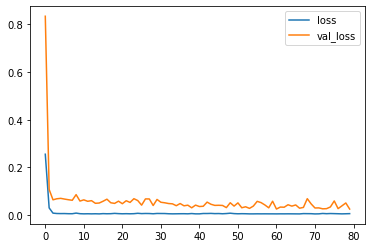

In [69]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


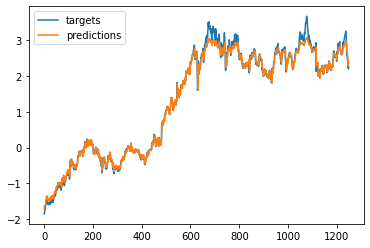

In [70]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()

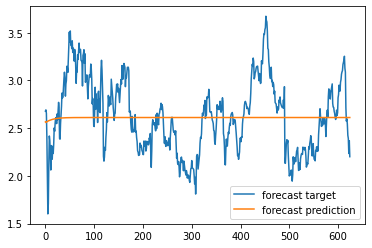

In [71]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

##Observations on method 1
Model performed very poorly when predicting next price using only previous prices 


```
Reasons and conclusion is discussed in the end
```


# Method 2
Instead of predicting next price using previous price we will try to predict 'Returns' in the stock price. i.e By how much percent will the price go up or down.

In [72]:
# Add a new column of Previous day closing price 
df['prevClose'] = df['close'].shift(1) #shifting closing price by 1 in new column

# new column will look like this
# close  | prev close
# x[2]   | x[1]
# x[3]   | x[2]

In [73]:
df.head()

,date,open,high,low,close,volume,Name,prevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [74]:
# return is defined as 
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['prevClose'])/df['prevClose']

In [75]:
df.head()

,date,open,high,low,close,volume,Name,prevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


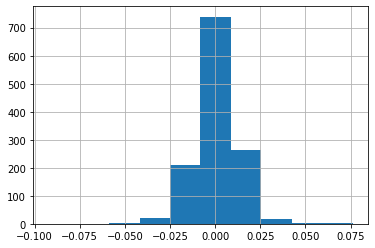

In [76]:
df['Return'].hist()

In [77]:
# Following steps are same as in Method 1, in method 1 we predictied actual price
# Here we will try to predict returns on the stock price. Hence only series is 
# changed, the model and other steps are same

series = df['Return'].values[1:].reshape(-1, 1)

# Normalizing data 
scaler = StandardScaler()
scaler.fit(series[:len(series)//2]) #using half data for training, scaler is fit on half data only
series = scaler.transform(series).flatten()


# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

#building RNN model 
_input = Input(shape=(T, 1))
x = LSTM(5)(_input)
out = Dense(1)(x)
model = Model(_input, out)
model.compile(
    loss = 'mse',
    optimizer = Adam(lr=0.1)
)

r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

X.shape (1248, 10, 1) Y.shape (1248,)
Epoch 1/80
20/20 [==============================] - 1s 26ms/step - loss: 1.0238 - val_loss: 1.1548
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9929 - val_loss: 1.1463
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9951 - val_loss: 1.1444
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 1.0021 - val_loss: 1.1863
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9907 - val_loss: 1.1577
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9902 - val_loss: 1.1635
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9964 - val_loss: 1.2132
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9809 - val_loss: 1.1659
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9803 - val_loss: 1.1973
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9726

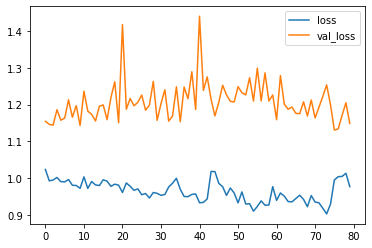

In [78]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


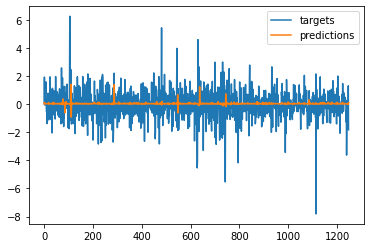

In [79]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

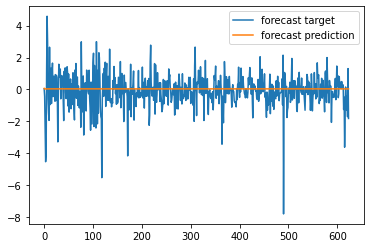

In [80]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## Observations on method 2
Model performed poorly as infered from the graphs 



```
Reasons and conclusion is discussed in the end
```



# Method 3
In the previous methods we tried to predict the price. In this method instead  of predicting price we will try to predict whether the price will go Up or down. This simplifies the problem to binary classification. We will also make use of all the features in this method

In [81]:
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [82]:
# building data that will go in neural network
T = 10 # Using previous T observations to predict the next observation
D = input_data.shape[1] # number of features in a single observation
N = len(input_data) - T

In [83]:
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [84]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [85]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain )

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [86]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x) #beacause this case is similar to binary classification
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [87]:
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 1s 23ms/step - loss: 0.6932 - accuracy: 0.5066 - val_loss: 0.6936 - val_accuracy: 0.4805
Epoch 2/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5221 - val_loss: 0.6980 - val_accuracy: 0.4829
Epoch 3/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5328 - val_loss: 0.6935 - val_accuracy: 0.4976
Epoch 4/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.5221 - val_loss: 0.6959 - val_accuracy: 0.4854
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6899 - accuracy: 0.5328 - val_loss: 0.6911 - val_accuracy: 0.5195
Epoch 6/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5268 - val_loss: 0.6973 - val_accuracy: 0.4878
Epoch 7/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6889 - accuracy: 0.5387 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 8/300


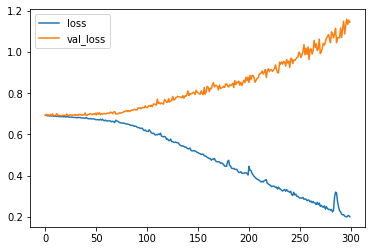

In [88]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

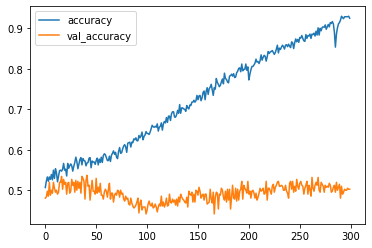

In [89]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Observations on method 1
This method seems to perform good at the first glance, val_loss was only 0.0194 on the last iterataion. In single step forcast it actually performed well. However when predicting multiple steps into the future the model performed very poorly. 

## Observations on method 2 
In method 2 we tried to predict returns on the stock price, in real world scenario people often talk about gains on a stock instead of actual price. Even with this method the accuracy was poor.

## Observations on method 3 
In method 3 we reducted the problem to binary classification. This is much easier task than compared to predicting actual price. Using this method train accuracy was 93%, however the test accuracy was only 50% which is not better than random guessing.
Method 3 was much easier task than that of method 1 and method 2. Since the model fails to perform well even on this taks, it would not have worked in predicting actual price even with hyperparameter tuning.

## Fundamental flaw in the approach
Predcting prices from previous prices may seem possible at first glance, however there is a fundamental flaw in this approach. This approach doesn't take into account real world events. 

Stock prices does not depent only on the previous prices. It can be on of the factors. 
Future is not completely deterministic from historical events. 
A more realistic scenario would be that the prices depend on the emotions of the investors, how media portrays the company etc. 

Our next target is to use these real world information about the company and economy to try to predict the prices
